## Problem 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib as mpl

from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence

%pylab inline

def transitionMatrixG(G):
    """input G: a graph.
    output T: the transition matrix of G,
    column normalized.
    """
    A = nx.to_numpy_array(G)
    T = A.T / A.sum(axis=1)
    return T

def coreTransitionMatrixG(G):
    """Similar to transitionMatrixG but 
    Returns the core normalized transition matrix of G.
    The cloumns are normalized.
    """
    A = nx.to_numpy_array(G)
    coreness = nx.core_number(G)
    coreness = np.array([coreness[k] for k in range(len(coreness))])
    A = A * coreness
    T = A.T / A.sum(axis=1)
    #T.sum(axis=0)
    return T

def diffusionMatrix(T, alpha=0.2):
    """
    input T: a transition matrix (column normalized).
    input alpha: a the restart probability.
    Output K: the diffusion matrix, which is
    K = a [I - (1-a)T]^(-1)
    """
    n = T.shape[0]
    I = np.identity(n)
    K = I - (1 - alpha)*T
    K = alpha * np.linalg.inv(K)
    return K

def diffusionMatrixG(G, alpha=0.2, coreness=False):
    """
    input G: a networkz graph.
    input alpha: the restart parameter.
    input bool coreness: If True, the normalization uses core number rather
    than the standard adjacency matrix.
    Output K: the diffusion matrix, which is
    K = a [I - (1-a)T]^(-1)
    """
    #A = nx.to_numpy_array(G)
    #T = A.T / A.sum(axis=1)
    if coreness:
        T = coreTransitionMatrixG(G)
    else:
        T = transitionMatrixG(G)
    n = T.shape[0]
    I = np.identity(n)
    K = I - (1 - alpha)*T
    K = alpha * np.linalg.inv(K)
    return K


def RWR(T, alpha=0.2, q=1, epsilon=1e-6, maxiter=10**6):
    """Calculates the stationary distribution of a RWR process
    using the power method.
    input T: a transition matrix (column normalized).
    input alpha: restart probability.
    input q: restart distribution. If none is provided the uniform distribution
    is used (pageRank).
    input epsilon: the stop condition for the convergence.
    input maxiter: maximum number of iterations if convergence isn't reached.
    output p: the stationary distribution
    """
    n = T.shape[0]
    if q==1:
        q = 1/n * np.ones(n)
    x = q
    y = alpha * q + (1 - alpha) * np.dot(T, x)
    #while np.linalg.norm((x-y)) > epsilon:
    for _ in range(maxiter):
        x = y
        y = alpha * q + (1 - alpha) * np.dot(T, x)
        if np.linalg.norm((x-y)) < epsilon:
            break
    return y

def RWRG(G, alpha=0.2, q=1, epsilon=1e-6, maxiter=10**6):
    """Calculates the stationary distribution of a RWR process
    using the power method.
    input G: a networkx graph.
    input alpha: restart probability.
    input q: restart distribution. If none is provided the uniform distribution
    is used (pageRank).
    input epsilon: the stop condition for the convergence.
    input maxiter: maximum number of iterations if convergence isn't reached.
    output p: the stationary distribution
    outut c: vector with the difference between iterations (convergence)
    """
    A = nx.to_numpy_array(G)
    #T = A.T / A.sum(axis=1)
    s =  A.sum(axis=1)
    s = s + (s == 0) # flip 0s
    T = A.T / s
    n = T.shape[0]
    c = np.zeros(maxiter)
    if q==1:
        q = 1/n * np.ones(n)
    x = q
    y = alpha * q + (1 - alpha) * np.dot(T, x)
    #while np.linalg.norm((x-y)) > epsilon:
    for i in range(maxiter):
        x = y
        y = alpha * q + (1 - alpha) * np.dot(T, x)
        c[i] = np.linalg.norm((x-y))
        if  c[i] < epsilon:
            break
    return y,c

#rs = RandomState(MT19937(SeedSequence(42)))

Populating the interactive namespace from numpy and matplotlib


## (C) Create the following 5 random networks (remember to use a seed= 42) using networkX:
- Erdős-Rényi (for n = 100, p = {0.01, 0.08, 0.4}),
- Watts-Strogatz (for n = 50, k = 7, p = 0.3)
- Barabási-Albert (for n = 50 and m = 3).

### Erdős-Rényi (for n = 100, p = 0.01)

In [53]:
G1 = nx.erdos_renyi_graph(n=100, p=0.01, seed=42)
y1,c1 = RWRG(G1, alpha=0.15, q=1)
q1 = np.ones(100)/100
y1.sum()

0.6939999999999998

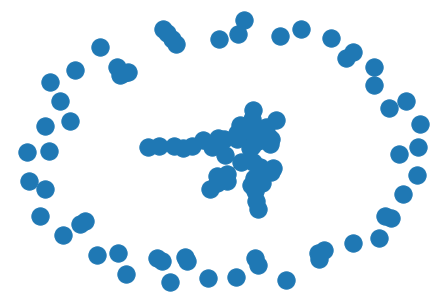

In [11]:
nx.draw_spring(G1)

In [17]:
K1 = diffusionMatrixG(G1, alpha=0.15)
p1 = np.dot(K1,q1)
print("Difference between both RWR methods:", np.linalg.norm(y1-p1))

Difference between both RWR methods: nan


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


The graph is not connected and some of the vertices have $0$ edges. Therefore this graph is not stochastic because a vertex without edges doesn't have a transition distribution.
So we can't really talk about pageRank of this graph.

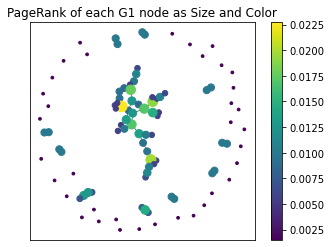

In [14]:
plt.imshow(y1.reshape((10,10)))
plt.colorbar()
plt.cla()
pos = nx.layout.spring_layout(G1)
nodes = nx.draw_networkx_nodes(G1, pos, node_size=5000*y1, node_color=y1, cmap=plt.cm.viridis)
edges = nx.draw_networkx_edges(G1,pos,width=0.5)
plt.title("PageRank of each G1 node as Size and Color")
plt.show()

In [60]:
print("All pagerank values:")
for node, rank in zip(G1.nodes(), y1):
    print(node, ":", rank)

All pagerank values:
0 : 0.00571489608786104
1 : 0.007702588999769012
2 : 0.009931270583889268
3 : 0.009468170029973142
4 : 0.0127794629255878
5 : 0.0015
6 : 0.0015
7 : 0.009738816514354999
8 : 0.0015
9 : 0.008912444439415692
10 : 0.01
11 : 0.0015
12 : 0.01257947536010542
13 : 0.0015
14 : 0.0015
15 : 0.007702588999769012
16 : 0.0015
17 : 0.0015
18 : 0.0015
19 : 0.0015
20 : 0.019835127785025056
21 : 0.0015
22 : 0.0052915755187352915
23 : 0.0015
24 : 0.016924176449673655
25 : 0.00701754385964912
26 : 0.0015
27 : 0.014594822000461973
28 : 0.01
29 : 0.01
30 : 0.01913516241885217
31 : 0.0015
32 : 0.0052765458491523184
33 : 0.009427148492464923
34 : 0.0015
35 : 0.005894086966860439
36 : 0.01
37 : 0.013381932593035559
38 : 0.00571489608786104
39 : 0.005566219402370979
40 : 0.012982456140350875
41 : 0.0015
42 : 0.008741561707967714
43 : 0.009283058291206799
44 : 0.0015
45 : 0.009974720805407398
46 : 0.0015
47 : 0.0015
48 : 0.0015
49 : 0.01
50 : 0.00936893723424102
51 : 0.01
52 : 0.006154724734

In [20]:
# T = np.nan_to_num(A / A.sum(axis=0))
# T.sum()

### Erdős-Rényi (for n = 100, p = 0.08)

In [21]:
G2 = nx.erdos_renyi_graph(n=100, p=0.08, seed=42)
y2,c2 = RWRG(G2, alpha=0.15, q=1)
q2 = np.ones(100)/100
y2.sum()

0.9999999999999996

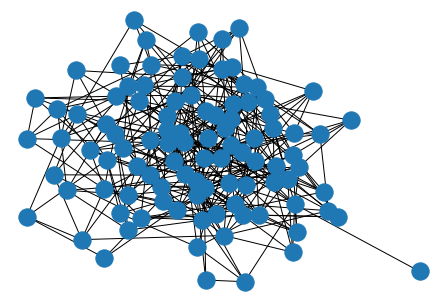

In [52]:
nx.draw_spring(G2)

In [24]:
K2 = diffusionMatrixG(G2, alpha=0.15)
p2 = np.dot(K2,q2)
print("Difference between both RWR methods:", np.linalg.norm(y2-p2)) # we see that both methods give very similar result

Difference between both RWR methods: 3.7494711607160316e-07


In [34]:
numIters2 = (c2 > 0).sum()
print("Number of Iterations till convergence:", numIters2)

Number of Iterations till convergence: 15


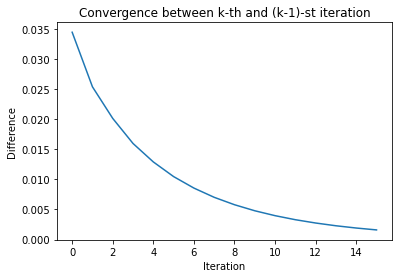

In [35]:
plt.plot(np.arange(numIters2+1),c[:numIters2+1])
plt.ylabel("Difference")
plt.xlabel("Iteration")
plt.title("Convergence between k-th and (k-1)-st iteration")
plt.show()

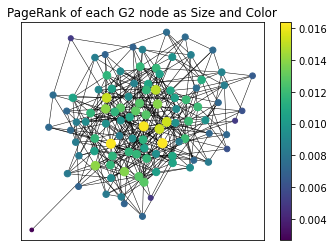

In [23]:
plt.imshow(y2.reshape((10,10)))
plt.colorbar()
plt.cla()
pos = nx.layout.spring_layout(G2)
nodes = nx.draw_networkx_nodes(G2, pos, node_size=5000*y2, node_color=y2, cmap=plt.cm.viridis)
edges = nx.draw_networkx_edges(G2,pos,width=0.5)
plt.title("PageRank of each G2 node as Size and Color")
plt.show()

In [61]:
print("All pagerank values:")
for node, rank in zip(G2.nodes(), y2):
    print(node, ":", rank)

All pagerank values:
0 : 0.011749878209451637
1 : 0.009465248127316207
2 : 0.010514319992097298
3 : 0.010830585679058487
4 : 0.010460926095139563
5 : 0.010625321938303931
6 : 0.008606758920755157
7 : 0.008502462790574681
8 : 0.007378333661641805
9 : 0.007155245990874632
10 : 0.011693165073391774
11 : 0.009237139161359468
12 : 0.014963756279054077
13 : 0.010868164869989096
14 : 0.008495207671811283
15 : 0.012781847232808239
16 : 0.009093824970101923
17 : 0.011805817606789497
18 : 0.006611326057421513
19 : 0.008490508968972797
20 : 0.007454687064277814
21 : 0.011661695420044386
22 : 0.011753558277567685
23 : 0.0026934449972816966
24 : 0.01636064210204045
25 : 0.009549916946910339
26 : 0.005080451416852819
27 : 0.013995416993002366
28 : 0.009339344620407601
29 : 0.008377616699155661
30 : 0.015214186210240227
31 : 0.01208564653646586
32 : 0.011493077140092709
33 : 0.009561960909723506
34 : 0.015311283550313231
35 : 0.007270577408410804
36 : 0.007051503375088265
37 : 0.013848726969141937
38

### Erdős-Rényi (for n = 100, p = 0.4)

In [31]:
G3 = nx.erdos_renyi_graph(n=100, p=0.4, seed=42)
y3,c3 = RWRG(G3, alpha=0.15, q=1)
q3 = np.ones(100)/100
y3.sum()

0.9999999999999996

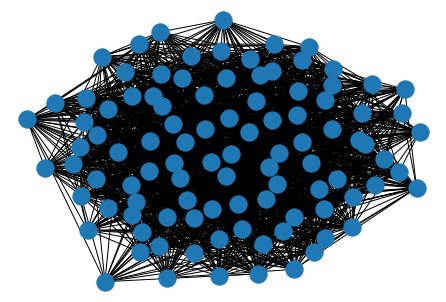

In [51]:
nx.draw_spring(G3)

In [33]:
K3 = diffusionMatrixG(G3, alpha=0.15)
p3 = np.dot(K3,q3)
print("Difference between both RWR methods:", np.linalg.norm(y3-p3)) # we see that both methods give very similar result

Difference between both RWR methods: 1.6364350313944108e-07


In [36]:
numIters3 = (c3 > 0).sum()
print("Number of Iterations till convergence:", numIters3)

Number of Iterations till convergence: 5


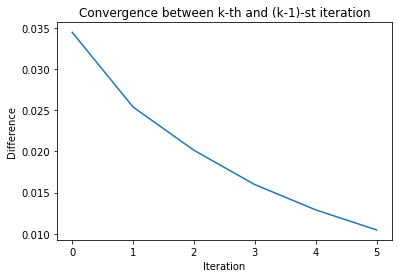

In [37]:
plt.plot(np.arange(numIters3+1),c[:numIters3+1])
plt.ylabel("Difference")
plt.xlabel("Iteration")
plt.title("Convergence between k-th and (k-1)-st iteration")
plt.show()

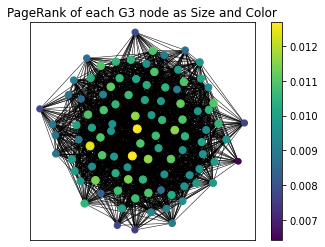

In [32]:
plt.imshow(y3.reshape((10,10)))
plt.colorbar()
plt.cla()
pos = nx.layout.spring_layout(G3)
nodes = nx.draw_networkx_nodes(G3, pos, node_size=5000*y3, node_color=y3, cmap=plt.cm.viridis)
edges = nx.draw_networkx_edges(G3,pos,width=0.5)
plt.title("PageRank of each G3 node as Size and Color")
plt.show()

In [62]:
print("All pagerank values:")
for node, rank in zip(G3.nodes(), y3):
    print(node, ":", rank)

All pagerank values:
0 : 0.011639117850394565
1 : 0.00963237330709581
2 : 0.009857843972450276
3 : 0.010105639246459377
4 : 0.008806032119144921
5 : 0.009670513223449643
6 : 0.009663641725543865
7 : 0.009001737050334078
8 : 0.007519675464541473
9 : 0.008817448172728599
10 : 0.009869813794178244
11 : 0.009202749787044474
12 : 0.010954958295328408
13 : 0.009641122596384232
14 : 0.01053574384344565
15 : 0.009684013575482294
16 : 0.009871689610652669
17 : 0.009021349903312924
18 : 0.009718688345388353
19 : 0.009651115411778531
20 : 0.009500116557377243
21 : 0.008597458993464629
22 : 0.01098340166396368
23 : 0.009049624951346803
24 : 0.010104339931135334
25 : 0.010752669089095376
26 : 0.007715435265582642
27 : 0.009848706123604887
28 : 0.010106136073615416
29 : 0.009671512707003147
30 : 0.01119177624938665
31 : 0.008826253012127696
32 : 0.01054049272319639
33 : 0.009901595222109257
34 : 0.011147630855318882
35 : 0.008630576300548011
36 : 0.010116022084589215
37 : 0.012666562779214859
38 : 0

### Watts-Strogatz (for n = 50, k = 7, p = 0.3)

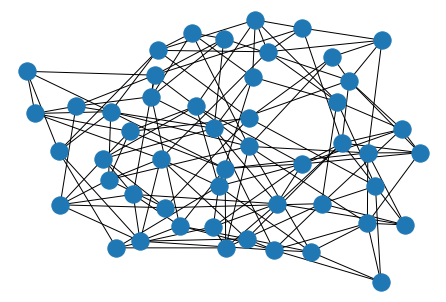

In [40]:
G4 = nx.watts_strogatz_graph(n=50, k=7, p=0.3, seed=42)
q4 = np.ones(50)/50
nx.draw_spring(G4)

In [41]:
y4,c4 = RWRG(G4, alpha=0.15, q=1)
y4.sum()

0.9999999999999996

In [48]:
K4 = diffusionMatrixG(G4, alpha=0.15)
p4 = np.dot(K4,q4)
print("Difference between both RWR methods:", np.linalg.norm(y4-p4)) # we see that both methods give very similar result

Difference between both RWR methods: 1.0868785762758303e-06


Number of Iterations till convergence: 16


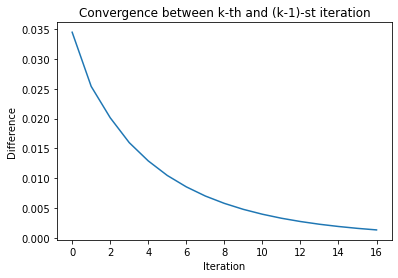

In [45]:
numIters4 = (c4 > 0).sum()
print("Number of Iterations till convergence:", numIters4)
plt.plot(np.arange(numIters4+1),c[:numIters4+1])
plt.ylabel("Difference")
plt.xlabel("Iteration")
plt.title("Convergence between k-th and (k-1)-st iteration")
plt.show()

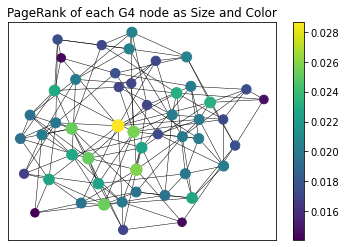

In [56]:
plt.imshow(y4.reshape((10,5)))
plt.colorbar()
plt.cla()
pos = nx.layout.spring_layout(G4)
nodes = nx.draw_networkx_nodes(G4, pos, node_size=5000*y4, node_color=y4, cmap=plt.cm.viridis)
edges = nx.draw_networkx_edges(G4,pos,width=0.5)
plt.title("PageRank of each G4 node as Size and Color")
plt.show()

In [63]:
print("All pagerank values:")
for node, rank in zip(G4.nodes(), y4):
    print(node, ":", rank)

All pagerank values:
0 : 0.023296177814411886
1 : 0.017576840897649916
2 : 0.023237885380037564
3 : 0.017231217245334832
4 : 0.020098957633082715
5 : 0.017109819591521042
6 : 0.025640500959879547
7 : 0.01728582882946785
8 : 0.017248993929739602
9 : 0.017135412637715303
10 : 0.020374716765371552
11 : 0.0203814608291317
12 : 0.020072387666177464
13 : 0.020549166254589402
14 : 0.02015783996532755
15 : 0.02278543396413318
16 : 0.017656191212874497
17 : 0.02030331491279442
18 : 0.017301899698200125
19 : 0.020089043962648327
20 : 0.0200319944377319
21 : 0.020115731787028197
22 : 0.01978194933938149
23 : 0.01997791783665201
24 : 0.022719163999173526
25 : 0.01959757857291608
26 : 0.01951912639598511
27 : 0.025306507524790904
28 : 0.014069830799798549
29 : 0.019634721024229508
30 : 0.022595956215818943
31 : 0.0286467441418698
32 : 0.019782088193145052
33 : 0.016898124721865446
34 : 0.014454942394228922
35 : 0.017470717663728767
36 : 0.022876347398072046
37 : 0.01950424137513895
38 : 0.025256188

### Barabási-Albert (for n = 50 and m = 3)

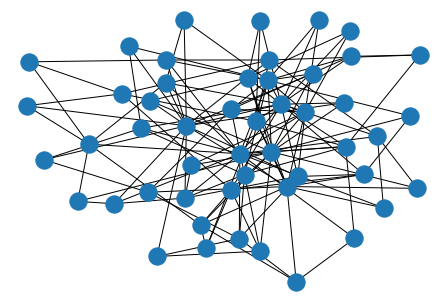

In [64]:
G5 = nx.barabasi_albert_graph(n=50, m=3, seed=42)
q5 = np.ones(50)/50
nx.draw_spring(G5)

In [65]:
y5,c5 = RWRG(G5, alpha=0.15, q=1)
y5.sum()

0.9999999999999998

In [66]:
K5 = diffusionMatrixG(G5, alpha=0.15)
p5 = np.dot(K5,q5)
print("Difference between both RWR methods:", np.linalg.norm(y5-p5)) # we see that both methods give very similar result

Difference between both RWR methods: 2.6716341454496354e-07


Number of Iterations till convergence: 20


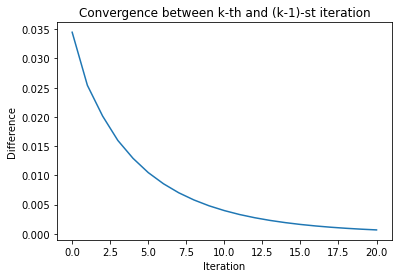

In [67]:
numIters5 = (c5 > 0).sum()
print("Number of Iterations till convergence:", numIters5)
plt.plot(np.arange(numIters5+1),c[:numIters5+1])
plt.ylabel("Difference")
plt.xlabel("Iteration")
plt.title("Convergence between k-th and (k-1)-st iteration")
plt.show()

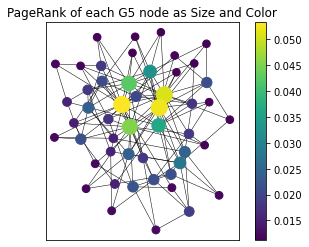

In [68]:
plt.imshow(y5.reshape((10,5)))
plt.colorbar()
plt.cla()
pos = nx.layout.spring_layout(G5)
nodes = nx.draw_networkx_nodes(G5, pos, node_size=5000*y5, node_color=y5, cmap=plt.cm.viridis)
edges = nx.draw_networkx_edges(G5,pos,width=0.5)
plt.title("PageRank of each G5 node as Size and Color")
plt.show()

In [69]:
print("All pagerank values:")
for node, rank in zip(G5.nodes(), y5):
    print(node, ":", rank)

All pagerank values:
0 : 0.02393378123421
1 : 0.05331557345802402
2 : 0.03246354716956735
3 : 0.050978127368944894
4 : 0.045378394548766895
5 : 0.04256705172199071
6 : 0.011250827813334339
7 : 0.020286822638053877
8 : 0.05237246092960013
9 : 0.03644269117771701
10 : 0.02114347104385858
11 : 0.02081431728975516
12 : 0.024021302699037007
13 : 0.014966268506538545
14 : 0.02769054349692764
15 : 0.01762471864162042
16 : 0.01773452898711803
17 : 0.011462927849418478
18 : 0.024299419415420655
19 : 0.015071690051659151
20 : 0.017944420134685512
21 : 0.02158102174693858
22 : 0.018132078028503824
23 : 0.011645656798328598
24 : 0.011322864680116715
25 : 0.021472879585911462
26 : 0.017961778517871625
27 : 0.018921043441236105
28 : 0.021307724361656934
29 : 0.011490359098228237
30 : 0.015248755867886588
31 : 0.011653605965325057
32 : 0.011911383529386494
33 : 0.015235837602693671
34 : 0.022189612995755684
35 : 0.018147003098186815
36 : 0.0113978693607951
37 : 0.012201199280803147
38 : 0.01190173930

### (E)
Try different initial distributions. Does it change the end result?

$p_0$ doesn't change the result, becaue $E \cdot v = (1/n,\dots,1/n)$ for any distribution vector, where $E$ is the matrix with all entries equal $1/n$.

### (G) 
In the Barabási-Albert network randomly assign the probabilities {0.4, 0.1, 0.5} to 3 nodes (the rest should have a 0 assigned) and propagate these scores in the network using the iterative approach in RWR. Plot how the PageRank value changes (X-axis - iteration, Y-axis - PageRank value) for all nodes (overlay the 50 lines in one figure).

In [85]:
def RWRG_all_iterations_new_transition(G, new_probabilities, alpha=0.2, q=1, epsilon=1e-6, maxiter=10**6):
    """Calculates the stationary distribution of a RWR process
    using the power method.
    input G: a networkx graph.
    input alpha: restart probability.
    input q: restart distribution. If none is provided the uniform distribution
    is used (pageRank).
    input epsilon: the stop condition for the convergence.
    input maxiter: maximum number of iterations if convergence isn't reached.
    output p: the stationary distribution
    outut c: vector with the difference between iterations (convergence)
    """
    A = nx.to_numpy_array(G)
    #T = A.T / A.sum(axis=1)
    s =  A.sum(axis=1)
    s = s + (s == 0) # flip 0s
    #T = A.T / s
    T = np.zeros((A.shape[0], A.shape[1]))
    rand_pos = np.random.choice(T.shape[0], len(new_probabilities), replace=False)
    for pos, new_prob in zip(rand_pos, new_probabilities):
        T[:, pos] =  new_prob
        T[pos, :] =  new_prob
    n = T.shape[0]
    c = np.zeros(maxiter)
    if q==1:
        q = 1/n * np.ones(n)
    x = q
    y_list = []
    y_list.append(alpha * q + (1 - alpha) * np.dot(T, x))
    for i in range(maxiter):
        x = y_list[-1]
        y_list.append(alpha * q + (1 - alpha) * np.dot(T, x))
        c[i] = np.linalg.norm((x-y_list[-1]))
        if  c[i] < epsilon:
            break
    return y_list,c

In [91]:
y_list6, c6 = RWRG_all_iterations_new_transition(G5, new_probabilities=[0.4, 0.1, 0.5], alpha=0.15, q=1)
#y5.sum()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in subtract


In [113]:
y_list6[0]

array([0.02  , 0.02  , 0.02  , 0.02  , 0.02  , 0.02  , 0.02  , 0.02  ,
       0.02  , 0.02  , 0.02  , 0.02  , 0.02  , 0.02  , 0.02  , 0.02  ,
       0.0948, 0.02  , 0.02  , 0.3396, 0.02  , 0.02  , 0.02  , 0.02  ,
       0.02  , 0.02  , 0.02  , 0.02  , 0.02  , 0.02  , 0.02  , 0.02  ,
       0.02  , 0.02  , 0.02  , 0.02  , 0.02  , 0.02  , 0.02  , 0.02  ,
       0.02  , 0.02  , 0.02  , 0.02  , 0.02  , 0.02  , 0.02  , 0.02  ,
       0.428 , 0.02  ])

In [101]:
print(len(y_list6))
print(y_list6[-1])

1000001
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


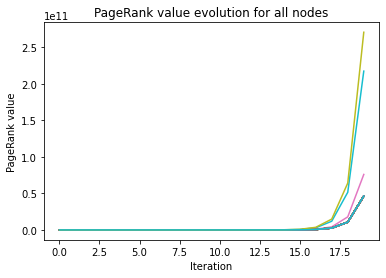

In [121]:
up_to = 20
x_vals = np.arange(len(y_list6[:up_to]))
for node_data in np.array(y_list6[:up_to]).T:
    plt.plot(x_vals, np.nan_to_num(node_data))
plt.xlabel("Iteration")
plt.ylabel("PageRank value")
plt.title("PageRank value evolution for all nodes")
plt.show()

### (H) 
In which iterations is there the largest change in the scores? Create 4 plots - each in a
different iteration to illustrate this change (the propagation). Let the color of the nodes represent the logarithmized PageRank value (to avoid errors add a pseudo-count of
0.0001) of the node after the respective iteration.

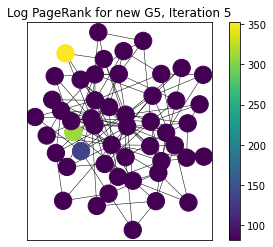

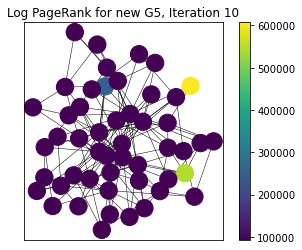

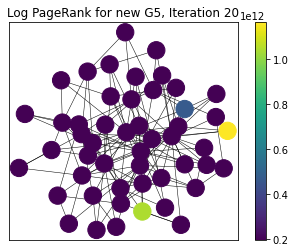

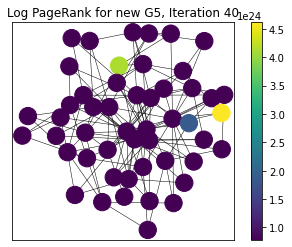

In [126]:
for i in [5, 10, 20, 40]:
    plt.imshow(y_list6[i].reshape((10,5)))
    plt.colorbar()
    plt.cla()
    pos = nx.layout.spring_layout(G5)
    nodes = nx.draw_networkx_nodes(G5, pos, node_color=np.log(y_list6[i]), cmap=plt.cm.viridis)
    edges = nx.draw_networkx_edges(G5,pos,width=0.5)
    plt.title(f"Log PageRank for new G5, Iteration {i}")
    plt.show()

### (I) 
Repeat the above two steps for the Watts-Strogatz network.

In [93]:
y_list7, c7 = RWRG_all_iterations_new_transition(G4, new_probabilities=[0.4, 0.1, 0.5], alpha=0.15, q=1)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in subtract


In [100]:
print(len(y_list7))
print(y_list7[-1])

1000001
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


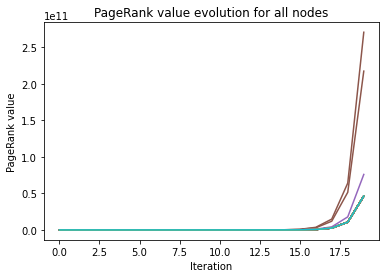

In [127]:
up_to = 20
x_vals = np.arange(len(y_list7[:up_to]))
for node_data in np.array(y_list7[:up_to]).T:
    plt.plot(x_vals, np.nan_to_num(node_data))
plt.xlabel("Iteration")
plt.ylabel("PageRank value")
plt.title("PageRank value evolution for all nodes")
plt.show()

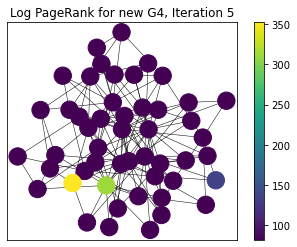

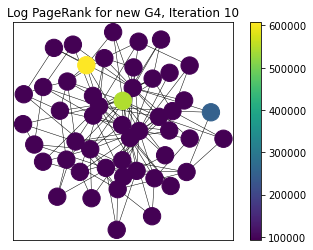

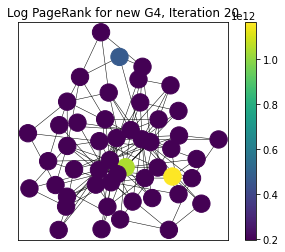

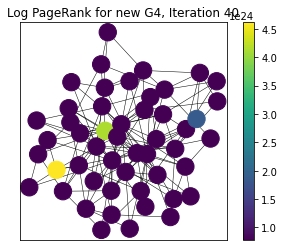

In [128]:
for i in [5, 10, 20, 40]:
    plt.imshow(y_list7[i].reshape((10,5)))
    plt.colorbar()
    plt.cla()
    pos = nx.layout.spring_layout(G5)
    nodes = nx.draw_networkx_nodes(G5, pos, node_color=np.log(y_list7[i]), cmap=plt.cm.viridis)
    edges = nx.draw_networkx_edges(G5,pos,width=0.5)
    plt.title(f"Log PageRank for new G4, Iteration {i}")
    plt.show()

### (J) 
Now calculate the propagation using the direct solution. Is it the same as the converged
iterative solution?

In [106]:
# for the Barabási-Albert network
New_probs = [0.4, 0.1, 0.5]
A6 = nx.to_numpy_array(G5)
T6 = np.zeros((A6.shape[0], A6.shape[1]))
rand_pos = np.random.choice(T6.shape[0], len(New_probs), replace=False)
for pos, new_prob in zip(rand_pos, New_probs):
    T6[:, pos] =  new_prob
    T6[pos, :] =  new_prob
K6 = diffusionMatrix(T6, alpha=0.15)
p6 = np.dot(K6,q5)
print(p6)
print("Difference between both RWR methods:", np.linalg.norm(y_list6[-1]-p6))

[-0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756
 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756
 -0.00020756 -0.00020756 -0.00020756 -0.00470009 -0.00020756 -0.00020756
 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756
 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756
 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756
 -0.00020756 -0.00020756 -0.00013805 -0.00020756 -0.00020756 -0.00020756
 -0.00352438 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756
 -0.00020756 -0.00020756]
Difference between both RWR methods: nan


In [105]:
# for the Watts-Strogatz network
New_probs = [0.4, 0.1, 0.5]
A7 = nx.to_numpy_array(G4)
T7 = np.zeros((A7.shape[0], A7.shape[1]))
rand_pos = np.random.choice(T7.shape[0], len(New_probs), replace=False)
for pos, new_prob in zip(rand_pos, New_probs):
    T7[:, pos] =  new_prob
    T7[pos, :] =  new_prob
K7 = diffusionMatrix(T7, alpha=0.15)
p7 = np.dot(K7,q4)
print(p7)
print("Difference between both RWR methods:", np.linalg.norm(y_list7[-1]-p7))

[-0.00020756 -0.00020756 -0.00020756 -0.00352438 -0.00020756 -0.00020756
 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756
 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756
 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756
 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00013805 -0.00470009
 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756
 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756
 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756 -0.00020756
 -0.00020756 -0.00020756]
Difference between both RWR methods: nan


Both iterative approaches just went to nan values and did never converge, therefore only the direct aproach provided a solution.